In [13]:

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [14]:
data = pd.read_csv("encoded_data.csv")
# Separate features from outcome
X = data.drop(columns="status")
y = data["status"]

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


In [15]:
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        # self.hidden = nn.Linear(60, 180)
        self.hidden = nn.Linear(16, 64)
        self.relu = nn.ReLU()
        # self.output = nn.Linear(180, 1)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer1 = nn.Linear(60, 60)
        self.layer1 = nn.Linear(16, 16)
        self.act1 = nn.ReLU()
        # self.layer2 = nn.Linear(60, 60)
        self.layer2 = nn.Linear(16, 16)
        self.act2 = nn.ReLU()
        # self.layer3 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(16, 16)
        self.act3 = nn.ReLU()
        # self.output = nn.Linear(60, 1)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [16]:
# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

1153
833


In [17]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [18]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [19]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (wide): 0.67
Accuracy (wide): 0.90
Accuracy (wide): 0.77
Accuracy (wide): 0.90
Accuracy (wide): 0.80
Accuracy (deep): 0.93
Accuracy (deep): 0.87
Accuracy (deep): 0.90
Accuracy (deep): 0.80
Accuracy (deep): 0.83
Wide: 80.67% (+/- 8.79%)
Deep: 86.67% (+/- 4.71%)


In [20]:
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()

acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()

Retrain a deep model
Final model accuracy: 86.15%


Deep(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

[ 1.   78.5   1.   65.5   1.   67.    1.   95.    1.   64.86  0.    0.
  1.    0.    0.    1.  ] -> [0.81846625] (expected [1.])
[ 0.   77.    0.   61.    0.   68.    1.   57.5   1.   61.31  0.    1.
  0.    1.    0.    0.  ] -> [0.8522209] (expected [1.])
[ 1.   60.    0.   67.    0.   70.    1.   50.48  1.   77.89  1.    0.
  0.    1.    0.    0.  ] -> [0.26980573] (expected [1.])
[ 0.  73.   0.  63.   0.  66.   0.  89.   1.  60.5  0.   0.   1.   1.
  0.   0. ] -> [0.77014244] (expected [1.])
[ 0.   73.    0.   58.    0.   66.    0.   53.7   0.   56.86  0.    0.
  1.    1.    0.    0.  ] -> [0.80272883] (expected [1.])


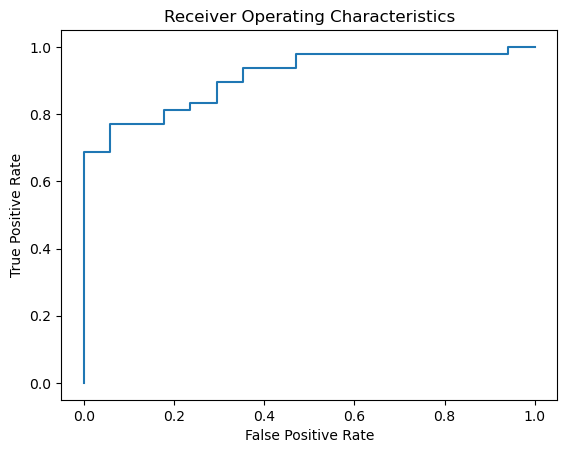

In [21]:
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()